# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов: 

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [1]:
%env TF_ENABLE_ONEDNN_OPTS=0

env: TF_ENABLE_ONEDNN_OPTS=0


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
print(tf.__version__)
print(keras.__version__)

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

# Загружаем данные

In [4]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [6]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

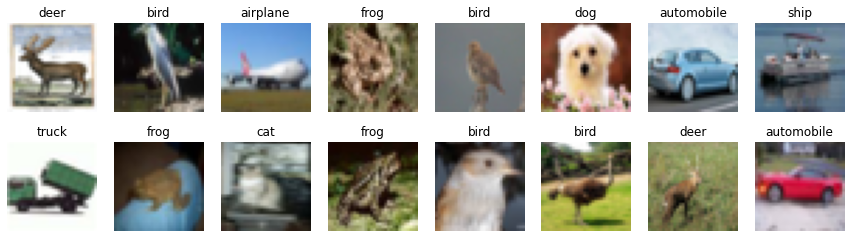

In [7]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [8]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [9]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе; 
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [10]:
def make_default_model(activation='relu', batch=False):
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', activation=activation, input_shape=(32, 32, 3)))
    if batch:
        model.add(BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same', activation=activation))
    if batch:
        model.add(BatchNormalization())    
    model.add(L.MaxPool2D())
    model.add(L.Dropout(.25))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same', activation=activation))
    if batch:
        model.add(BatchNormalization())    
    model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same', activation=activation))
    if batch:
        model.add(BatchNormalization())    
    model.add(L.MaxPool2D())
    model.add(L.Dropout(.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='elu'))
    if batch:
        model.add(BatchNormalization())    
    model.add(L.Dropout(.5))
    model.add(L.Dense(10, activation='softmax')) # activation='softmax'
    return model

In [11]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                        

2022-07-23 16:55:37.645963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 16:55:37.731561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 16:55:37.731700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 16:55:37.732605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [14]:
!nvidia-smi # -L

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sat Jul 23 17:17:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   54C    P2   151W / 350W |  10365MiB / 12288MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+-------------------

# Тренируем модель

In [15]:
def train_model(make_model_func=make_default_model, activation='relu', optimizer='adam', batch=False):
    BATCH_SIZE = 32
    EPOCHS = 10

    K.clear_session()
    model = make_model_func(activation=activation, batch=batch)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    model.fit(
        x_train2, y_train2,  # нормализованные данные
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_test2, y_test2),
        shuffle=False
    )
  
    return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [16]:
# учим дефолтную архитектуру
model = train_model()

Epoch 1/10


2022-07-23 17:24:09.707223: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-07-23 17:24:11.371459: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-23 17:24:11.372006: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-23 17:24:11.372034: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-23 17:24:11.372484: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-23 17:24:11.372541: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-07-23 17:24:11.520842: I tensorflow/stream_executor/cuda/c

1563/1563 [==============================] - 9s 3ms/step - loss: 1.3909 - accuracy: 0.4975 - val_loss: 1.0368 - val_accuracy: 0.6375
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0201 - accuracy: 0.6407 - val_loss: 0.8755 - val_accuracy: 0.6856
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9022 - accuracy: 0.6834 - val_loss: 0.8314 - val_accuracy: 0.7054
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.8259 - accuracy: 0.7106 - val_loss: 0.7728 - val_accuracy: 0.7266
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.7775 - accuracy: 0.7289 - val_loss: 0.7984 - val_accuracy: 0.7245
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.7465 - accuracy: 0.7364 - val_loss: 0.7744 - val_accuracy: 0.7326
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7049 - accuracy: 0.7528 - val_loss: 0.7669 - val_accuracy: 0.7391
Epo

In [18]:
predicts = np.argmax(model.predict(x_test2), axis = 1)

313/313 [==============================] - 0s 1ms/step


In [19]:
print('Test Accuracy: ', accuracy_score(y_test, predicts))

Test Accuracy:  0.7619


In [20]:
predicts_train = np.argmax(model.predict(x_train2), axis = 1)

1563/1563 [==============================] - 2s 1ms/step


In [21]:
print('Test Accuracy on Train: ', accuracy_score(y_train, predicts_train))

Test Accuracy on Train:  0.84742


In [22]:
# учим sigmoid
model = train_model(activation='sigmoid')

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3407 - accuracy: 0.0978 - val_loss: 2.3038 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3029 - accuracy: 0.0992 - val_loss: 2.2334 - val_accuracy: 0.1408
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.9561 - accuracy: 0.2838 - val_loss: 1.7422 - val_accuracy: 0.3763
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.7193 - accuracy: 0.3789 - val_loss: 1.5762 - val_accuracy: 0.4296
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.5942 - accuracy: 0.4233 - val_loss: 1.4522 - val_accuracy: 0.4790
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.5045 - accuracy: 0.4586 - val_loss: 1.3776 - val_accuracy: 0.5097
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.4405 - accuracy: 0.4856 - val_loss: 1.3211 - val_accuracy:

In [23]:
predicts = np.argmax(model.predict(x_test2), axis = 1)
print('Test Accuracy: ', accuracy_score(y_test, predicts))

313/313 [==============================] - 0s 932us/step
Test Accuracy:  0.583


In [24]:
# учим sgd
model = train_model(optimizer="sgd")
predicts = np.argmax(model.predict(x_test2), axis = 1)
print('Test Accuracy: ', accuracy_score(y_test, predicts))

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.9326 - accuracy: 0.2948 - val_loss: 1.6148 - val_accuracy: 0.4195
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.5875 - accuracy: 0.4232 - val_loss: 1.4451 - val_accuracy: 0.4782
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.4184 - accuracy: 0.4866 - val_loss: 1.2886 - val_accuracy: 0.5352
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.2949 - accuracy: 0.5373 - val_loss: 1.1856 - val_accuracy: 0.5741
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.2026 - accuracy: 0.5732 - val_loss: 1.0923 - val_accuracy: 0.6122
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.1233 - accuracy: 0.6021 - val_loss: 1.0270 - val_accuracy: 0.6351
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.0617 - accuracy: 0.6260 - val_loss: 0.9534 - val_accuracy:

In [27]:
# батч нормализацию
model = train_model(batch=True)
predicts = np.argmax(model.predict(x_test2), axis = 1)
print('Test Accuracy: ', accuracy_score(y_test, predicts))

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4328 - accuracy: 0.5099 - val_loss: 0.9723 - val_accuracy: 0.6616
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9967 - accuracy: 0.6489 - val_loss: 0.8323 - val_accuracy: 0.7076
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8682 - accuracy: 0.6952 - val_loss: 0.7414 - val_accuracy: 0.7453
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7772 - accuracy: 0.7294 - val_loss: 0.7379 - val_accuracy: 0.7460
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7062 - accuracy: 0.7534 - val_loss: 0.6596 - val_accuracy: 0.7716
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6531 - accuracy: 0.7708 - val_loss: 0.6560 - val_accuracy: 0.7782
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6015 - accuracy: 0.7893 - val_loss: 0.6186 - val_accuracy:

In [26]:
model = train_model(activation='sigmoid', batch=True)
predicts = np.argmax(model.predict(x_test2), axis = 1)
print('Test Accuracy: ', accuracy_score(y_test, predicts))

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4844 - accuracy: 0.4941 - val_loss: 1.5235 - val_accuracy: 0.5638
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0619 - accuracy: 0.6300 - val_loss: 0.9971 - val_accuracy: 0.6546
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9475 - accuracy: 0.6704 - val_loss: 0.8860 - val_accuracy: 0.6941
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8792 - accuracy: 0.6937 - val_loss: 0.7994 - val_accuracy: 0.7209
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8215 - accuracy: 0.7136 - val_loss: 0.9116 - val_accuracy: 0.7130
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7740 - accuracy: 0.7290 - val_loss: 0.7299 - val_accuracy: 0.7440
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7312 - accuracy: 0.7419 - val_loss: 0.7086 - val_accuracy: